# Aggregate gridded data over geometry files

This notebook will demonstrate how to use the earthkit libraries to access some ERA5 data, perform some aggregations over geometry files then plot the results.

For this exercise we will use the earthkit-data package to access the data, earthkit-climate to calculate our climatologies and anomalies and earthkit-maps to plot the results. We will also access some geometries that we have stored for testing purposes.

The earthkit-climate routines are *currently* based on xarray, hence they return raw xarray objects. *This may change in future versions of Earthkit*.

In [ ]:
import numpy as np # Everyone loves a numpy!

from earthkit import data as ek_data
from earthkit.climate import aggregate as ek_aggregate
from earthkit import maps as ek_maps

# For this example we are going to use some geometry files we have stored for testing,
# but any geojson files or geopandas dataframes would work.
from earthkit.data.testing import earthkit_remote_test_data_file


# An extra to suppress some of the warnings we have in place whilst the code is in development
import warnings
warnings.filterwarnings("ignore")

In [2]:
cds_dataset_name = 'reanalysis-era5-single-levels'

# We use an Earthkit bounding box object to describe our area, this clears up any lack of clarity of the order of
#  North, South, East, West.

area = ek_data.utils.bbox.BoundingBox(north=80, south=20, west=-30, east=100)
cds_request = {
    'product_type': 'reanalysis',
    'variable': '2m_temperature',
    'year': [
        "2015",
    ],
    'month': [
        '01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12',
    ],
    'day': [
        '01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12',
        '13', '14', '15',
        '16', '17', '18',
        '19', '20', '21',
        '22', '23', '24',
        '25', '26', '27',
        '28', '29', '30',
        '31',
    ],
    'time': [
        '00:00', '06:00', '12:00', '18:00',
    ],
    'area': area
}
era5_data = ek_data.from_source("cds", cds_dataset_name, cds_request)


## Load your NUTS

Load the NUTS geometries from the geojson file we have stored in our test data repository. Visualising as a pandas dataframe is preferable.

In [3]:
# Use some demonstration polygons stored, this could be any url or path to geojson file
remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
nuts_data = ek_data.from_source("url", remote_nuts_url)

nuts_data.to_pandas()[:5]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160..."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7..."


## Mask dataarray with geodataframe

### `spatial.mask` 

`spatial.mask` applies all the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object the same shape and type as the input xarray object with all points outside of
the geometry masked

In [4]:
single_masked_data = ek_aggregate.spatial.mask(era5_data, nuts_data)
single_masked_data

<xarray.Dataset>
Dimensions:     (number: 1, time: 1460, step: 1, surface: 1, latitude: 241,
                 longitude: 521)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 -30.0 -29.75 -29.5 ... 99.5 99.75 100.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 na...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-06T14:10 GRIB to CDM+CF via cfgrib-0.9.1...

Then plot what we have done:

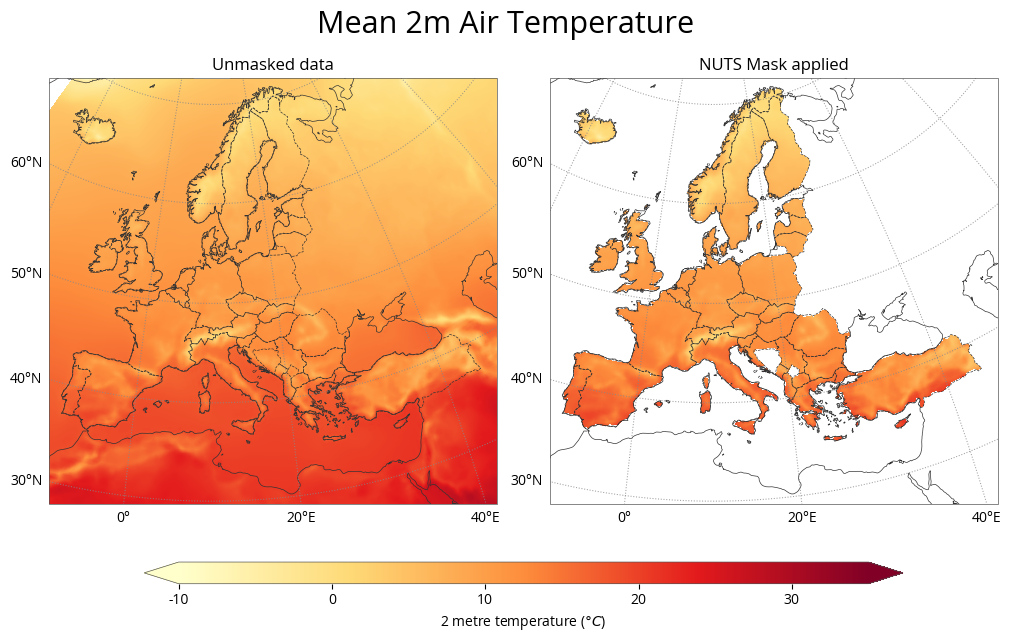

In [5]:
# We take the mean of our data in the time dimension for plotting purposes
mean_era5 = era5_data.to_xarray().t2m
mean_era5 = mean_era5.mean(dim='time').assign_attrs(mean_era5.attrs)

mean_masked_data = single_masked_data.t2m.mean(dim='time').assign_attrs(single_masked_data.t2m.attrs)

style = ek_maps.styles.Contour(
    colors=["#ffffcc","#fed976","#fd8d3c","#e31a1c","#800026"],  # Or provide a list of colours to interpolate
    levels=np.arange(-10, 35.01, 0.1),
    units="celsius",
    extend='both',  # How to handle out-of-bounds values, can be None (default), 'min', 'max' ot 'both'
    # The legend/colorbar ticks can be included here or when the legend is added
    ticks=np.arange(-10,36,10)
)

# Plot the 2 objects
chart = ek_maps.Superplot(domain="Europe", rows=1, cols=2)

subplot1 = chart.add_subplot()
subplot1.plot(mean_era5, style=style)
subplot1.title("Unmasked data")

subplot2 = chart.add_subplot()
subplot2.plot(mean_masked_data, style=style)
subplot2.title("NUTS Mask applied")

# earthkit maps is actually clever to figure all this out for you:
# chart = ek_maps.Superplot(domain="Europe")
# chart.plot([mean_era5, mean_masked_data], style=style)
# # Add subplot titles
# chart.subplot_titles("Unmasked data", "NUTS Mask applied")

chart.add_geometries(nuts_data)
# Ad chart title
chart.title("Mean 2m Air Temperature", fontsize=22, y=0.83)
# We can now add coastlines, gridlines and a legend
chart.coastlines(resolution='medium')
chart.gridlines()
chart.legend() # It is also possible to define the legend ticks here, this will override anything 

chart.show()

### `spatial.masks`

`shapes.masks` applies the features in the geometry object (`nuts_data`) to the data object (`era5_data`).
It returns an xarray object with an additional dimension, and coordinate variable, corresponding to the 
features in the geometry object.

By default this is the index of the input geodataframe, in this example the index is just an integer
count so it takes the default name `index`.

Also note that the returned object is a "chunked", this is built-in xarray functionality which uses dask
to store the object such that there is less stress on your computers RAM.


In [6]:
masked_data = ek_aggregate.spatial.masks(era5_data, nuts_data)
masked_data

<xarray.Dataset>
Dimensions:     (index: 37, number: 1, time: 1460, step: 1, surface: 1,
                 latitude: 241, longitude: 521)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 -30.0 -29.75 -29.5 ... 99.5 99.75 100.0
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(1460, 1), meta=np.ndarray>
  * index       (index) int64 0 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
Data variables:
    t2m         (index, number, time, step, surface, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1460, 1, 1, 241, 521), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-06T14:11 GRIB to CDM+CF via cfgrib-0.9.1...

It is possible to specify a column in the geodataframe to use for the new dimension, for example in NUTS the
`FID` (= feature id) which contains the two letter identier code for each feature:

In [7]:
masked_data = ek_aggregate.spatial.masks(era5_data, nuts_data, mask_dim="FID", all_touched=True)
masked_data

<xarray.Dataset>
Dimensions:     (FID: 37, number: 1, time: 1460, step: 1, surface: 1,
                 latitude: 241, longitude: 521)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 -30.0 -29.75 -29.5 ... 99.5 99.75 100.0
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(1460, 1), meta=np.ndarray>
  * FID         (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m         (FID, number, time, step, surface, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1460, 1, 1, 241, 521), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-06T14:12 GRIB to CDM+CF via cfgrib-0.9.1...

And then plot the difference:

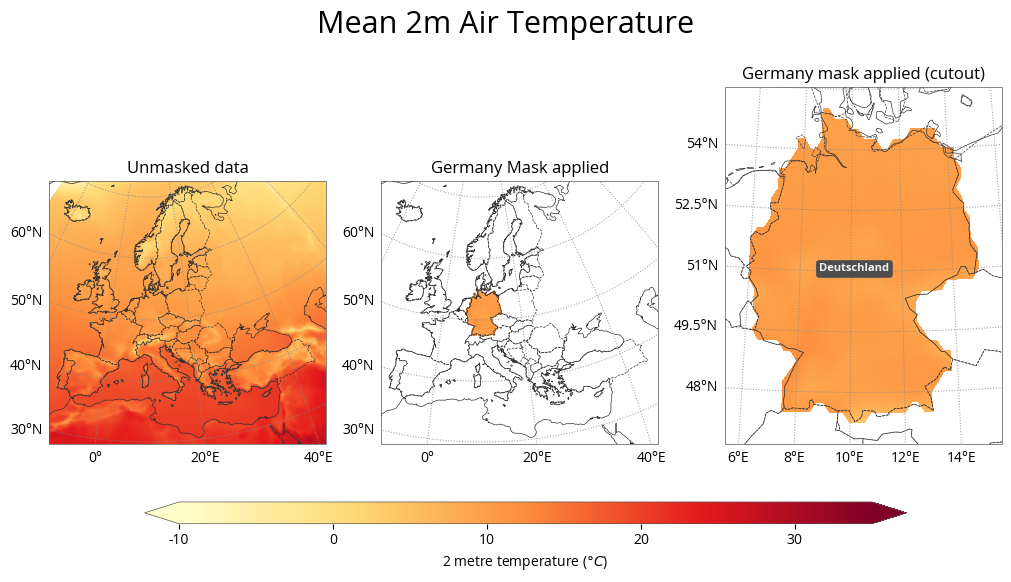

In [8]:
# We take the mean of our data in the time dimension for plotting purposes
germany_data = masked_data.sel(FID='DE')
mean_germany_data = germany_data.t2m.mean(dim='time').assign_attrs(masked_data.t2m.attrs)
germany_shape = nuts_data.to_pandas()[35:36]
plot_data = [mean_era5, mean_germany_data]
plot_titles = ["Unmasked data", "Germany Mask applied", "Germany mask applied (cutout)"]

style = ek_maps.styles.Contour(
    colors=["#ffffcc","#fed976","#fd8d3c","#e31a1c","#800026"],  # Or provide a list of colours to interpolate
    levels=np.arange(-10, 35.01, 0.1),
    units="celsius",
    extend='both',  # How to handle out-of-bounds values, can be None (default), 'min', 'max' ot 'both'
    # The legend/colorbar ticks can be included here or when the legend is added
    ticks=np.arange(-10,36,10)
)

# Plot the 3 objects
chart = ek_maps.Superplot(domain="Europe", rows=1, cols=3)

subplot1 = chart.add_subplot()
subplot1.plot(plot_data[0], style=style)
subplot1.title(plot_titles[0])

subplot2 = chart.add_subplot()
subplot2.plot(mean_germany_data, style=style)
subplot2.title(plot_titles[1])

subplot3 = chart.add_subplot(domain='Germany')
subplot3.plot(mean_germany_data, style=style)
subplot3.title(plot_titles[2])

# Add the nuts outlines to all subplots
chart.add_geometries(nuts_data)
# Add a nuts label to the germany plot
subplot3.add_geometries(germany_shape, labels='NUTS_NAME', linewidth=0)


# Add main title, y is requried as automatic position of the title is not yet working
chart.title("Mean 2m Air Temperature", fontsize=22, y=0.75)

# We can now add coastlines, gridlines and a legend
chart.coastlines(resolution='medium')
chart.gridlines()
chart.legend() # It is also possible to define the legend ticks here, this will override anything 

chart.show()

## Reduce (i.e. aggregate) the data over the shape
### Default behaviour

The default behaviour is to reduce the data along the spatial dimensions, only, and return the reduced data
in an Xarray format, i.e. `xr.DataArray` or `xr.Dataset`.

Using the same syntax as the `masks` function, we can provide a `mask_dim` use for the dimension created
when reducing the spatial dimensions. 
Here we choose the `FID` (feature id), and the coordinate variable created has the values
of the `FID` column in the input `geodataframe`.
If `mask_dim` is not provide a dimension called `index` is created.

The new variable name is made up of the original variable name and the method used to reduce, e.g. `t2m_mean`

In [10]:
reduced_data = ek_aggregate.spatial.reduce(era5_data, nuts_data, mask_dim="FID", all_touched=True)
reduced_data

<xarray.Dataset>
Dimensions:     (time: 1460, FID: 37)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * FID         (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m_mean    (FID, time) float32 278.7 279.8 279.8 ... 274.4 274.2 273.8
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-06T14:13 GRIB to CDM+CF via cfgrib-0.9.1...

We can plot the time series we have created using matplotlib methods (TODO: replace with earthkit-plots)

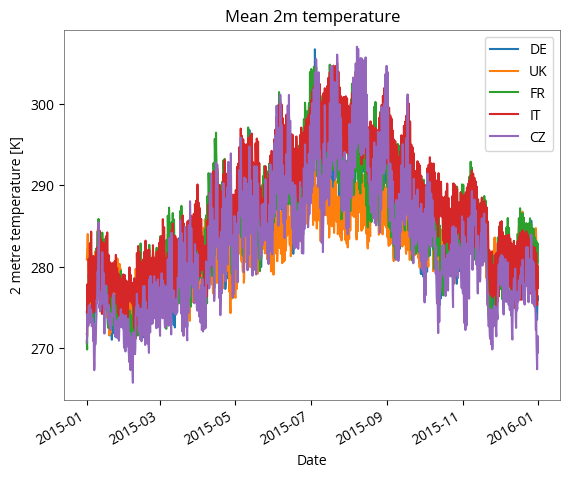

In [11]:
import matplotlib.pyplot as plt

for country in ["DE", "UK", "FR", "IT", "CZ"]:
    ax = reduced_data.t2m_mean.sel(FID=country).plot(label=country)
plt.title("Mean 2m temperature")
plt.xlabel("Date")
plt.legend()
plt.show()


### Reduce along additional dimension

For example, any time dimension, this is advisable as it ensures correct handling missing values and weights.

The extra_reduce_dims argument takes a single string or a list of strings corresponding to dimensions to
include in the reduction.

To make it super-simple to plot the returned object with earthkit-maps we will also include the geometry as a
coordinate in the xarray via the `return_geometry_as_coord`. This will add an additional coordinate variable
called `geometry` which contains the polygons that the data correspondes to. This is not the default behivour
as unfortunately it creates an xarray object which cannot be saved to netcdf.

In [12]:
reduced_data = ek_aggregate.spatial.reduce(
    era5_data, nuts_data, mask_dim="FID", extra_reduce_dims='time', all_touched=True,
    return_geometry_as_coord = True
)
reduced_data

<xarray.Dataset>
Dimensions:   (FID: 37)
Coordinates:
    number    int64 0
    step      timedelta64[ns] 00:00:00
    surface   float64 0.0
  * FID       (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CH' 'CY' 'CZ' 'DE' 'NO'
    geometry  (FID) object MULTIPOLYGON (((15.1629 55.0937, 15.094 54.9962, 1...
Data variables:
    t2m_mean  (FID) float32 282.5 285.0 280.6 288.2 ... 292.9 282.9 283.3 273.8
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-06T14:14 GRIB to CDM+CF via cfgrib-0.9.1...

### Weighted reduction

Provide numpy/xarray arrays of weights, or use predefined weights options, i.e. `latitude`:

In [13]:
reduced_data = ek_aggregate.spatial.reduce(
    era5_data, nuts_data, weights='latitude', mask_dim="FID", extra_reduce_dims='time', all_touched=True,
    return_geometry_as_coord = True
)
reduced_data

<xarray.Dataset>
Dimensions:   (FID: 37)
Coordinates:
    number    int64 0
    step      timedelta64[ns] 00:00:00
    surface   float64 0.0
  * FID       (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CH' 'CY' 'CZ' 'DE' 'NO'
    geometry  (FID) object MULTIPOLYGON (((15.1629 55.0937, 15.094 54.9962, 1...
Data variables:
    t2m_mean  (FID) float64 282.5 285.0 280.6 288.2 ... 292.9 282.9 283.3 275.2
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-09-06T14:14 GRIB to CDM+CF via cfgrib-0.9.1...

## Return as a pandas dataframe

**WARNING: Returning reduced data in pandas format is considered experimental and may change in 
future versions of earthkit-climate** 

It is possible to return the reduced data in a fully expanded geopandas dataframe which contains the geometry 
and aggregated data.
Additional columns for the data values and rows and indexes added to fully describe the reduced data.

The returned object fully supports pandas indexing and in-built convenience methods (e.g. plotting),
but it comes with memory usage cost, hence in this example we reduce along all dimensions.

In [14]:
reduced_data_pd = ek_aggregate.spatial.reduce(
    era5_data, nuts_data, return_as="pandas", mask_dim="FID", extra_reduce_dims="time"
)
reduced_data_pd

Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit-climate


,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,number,step,surface,t2m_mean
FID,,,,,,,,,,,,,,,
DK,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...",0,0 days,0.0,282.484314
RS,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160...",0,0 days,0.0,285.003693
EE,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57...",0,0 days,0.0,280.562836
EL,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35...",0,0 days,0.0,288.214996
ES,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7...",0,0 days,0.0,287.863861
FI,FI,FI,0,FI,Suomi/Finland,Suomi/Finland,0,0,0,FI,"MULTIPOLYGON (((28.89670 69.04260, 28.47820 68...",0,0 days,0.0,277.202789
FR,FR,FR,0,FR,France,France,0,0,0,FR,"MULTIPOLYGON (((55.84980 -21.18580, 55.78580 -...",0,0 days,0.0,285.116852
HR,HR,HR,0,HR,Hrvatska,Hrvatska,0,0,0,HR,"MULTIPOLYGON (((17.65150 45.84780, 17.91210 45...",0,0 days,0.0,285.964813
HU,HU,HU,0,HU,Magyarország,Magyarország,0,0,0,HU,"POLYGON ((22.12110 48.37830, 22.15530 48.40340...",0,0 days,0.0,285.277161


Above you can see that we have the geomatry information and the data stored in a single object.

This can be fed straight into earthkit-maps:

AttributeError: 'PandasSeriesWrapper' object has no attribute 'to_points'

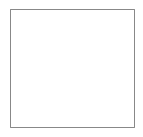

In [15]:
style = ek_maps.styles.Contour(
    colors=["#ffffcc","#fed976","#fd8d3c","#e31a1c","#800026"],  # Or provide a list of colours to interpolate
    levels=np.arange(-10, 35.01, 0.1),
    units="celsius",
    extend='both',  # How to handle out-of-bounds values, can be None (default), 'min', 'max' ot 'both'
    # The legend/colorbar ticks can be included here or when the legend is added
    ticks=np.arange(-10,36,10)
)

# Plot the 2 objects
chart = ek_maps.Superplot(domain="Europe")

chart.plot(reduced_data_pd, style=style)

chart.title("Mean 2m Air Temperature", fontsize=32, y=0.83)
# We can now add coastlines, gridlines and a legend
chart.coastlines(resolution='medium')
chart.gridlines()
chart.legend() # It is also possible to define the legend ticks here, this will override anything 

chart.show()